# Projet python sur l'étude de l'origine des changements de localisation

## 1. Création de la base de données
- On fusionne les bases de données et sélectionne les variables qui nous intéressent

In [39]:
import pandas as pd
import xlrd 
import matplotlib.pyplot as plt
from math import log
import seaborn as sns

In [41]:

df_logement2018 = pd.read_csv("./base-cc-logement-2018.csv", sep = ";", low_memory=False)

table_correspondance = pd.read_csv("./departements-francais.csv", sep  = "\t")[0:100]
df_logement2018

,CODGEO,P18_LOG,P18_RP,P18_RSECOCC,P18_LOGVAC,P18_MAISON,P18_APPART,P18_RP_1P,P18_RP_2P,P18_RP_3P,...,P08_RP_CLIM,P08_RP_TTEGOU,P08_RP_GARL,P08_RP_VOIT1P,P08_RP_VOIT1,P08_RP_VOIT2P,P08_RP_HABFOR,P08_RP_CASE,P08_RP_MIBOIS,P08_RP_MIDUR
0,01001,353.730435,311.000000,16.278261,26.452174,345.478380,6.209388,1.025276,3.076792,21.715515,...,NaN,NaN,250.662145,276.996301,108.262639,168.733662,NaN,NaN,NaN,NaN
1,01002,174.392742,105.156379,52.945455,16.290909,174.392742,0.000000,2.082305,2.082305,14.576132,...,NaN,NaN,62.707071,76.424242,31.353535,45.070707,NaN,NaN,NaN,NaN
2,01004,7341.584896,6531.148636,118.593433,691.842827,3103.486522,4183.217092,274.687218,879.420677,1803.837447,...,NaN,NaN,3723.283382,4719.997375,2802.868189,1917.129186,NaN,NaN,NaN,NaN
3,01005,773.926652,710.392817,4.632675,58.901159,574.130278,197.204148,5.791246,47.295174,95.555556,...,NaN,NaN,496.475248,553.686262,201.693069,351.993193,NaN,NaN,NaN,NaN
4,01006,75.546970,53.963636,12.333333,9.250000,70.456061,5.090909,0.000000,3.054545,7.127273,...,NaN,NaN,43.050000,49.200000,28.700000,20.500000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34988,97420,9170.187817,8515.285162,42.587533,612.315122,7088.618164,2049.113950,110.847072,597.346965,1638.539114,...,1042.606783,3373.621823,4256.327585,5162.523336,3359.680223,1802.843113,57.503491,531.417404,235.226329,6247.445796
34989,97421,3237.422083,2591.582784,193.945735,451.893563,3128.866898,63.766969,23.283752,100.221365,411.008832,...,8.856315,39.361398,1589.232460,1429.818799,1070.630021,359.188778,15.744559,281.433994,448.719935,1526.254223
34990,97422,34895.447032,31889.864227,931.563102,2074.019702,26832.328991,7899.560037,1547.668144,3176.368863,6586.666333,...,608.432805,5481.901462,20116.784310,19354.496763,13634.263014,5720.233749,192.160478,1536.642625,1031.795266,23285.847500
34991,97423,3095.862715,2657.986587,79.262346,358.613783,2828.361799,233.230068,40.673092,167.776506,538.918474,...,144.458389,199.490156,1543.837613,1533.027801,991.554520,541.473281,18.671492,280.072387,126.769607,1858.304854


In [42]:
for i in range(len(table_correspondance)):
    if len(table_correspondance['NUMÉRO'][i])==1:
           table_correspondance['NUMÉRO'][i] = "0" + table_correspondance['NUMÉRO'][i]
table_correspondance

<ipython-input-42-8ccc6f6fa3a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_correspondance['NUMÉRO'][i] = "0" + table_correspondance['NUMÉRO'][i]


,NUMÉRO,NOM,REGION,CHEF LIEU,SUPERFICIE (km²),POPULATION,DENSITE (habitants/km2)
0,01,Ain,Auvergne-Rhône-Alpes,Bourg-en-Bresse,5762.0,631877.0,109.7
1,02,Aisne,Hauts-de-France,Laon,7369.0,538659.0,73.1
2,03,Allier,Auvergne-Rhône-Alpes,Moulins,7340.0,341613.0,46.5
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,Digne,6925.0,161799.0,23.4
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,Gap,5549.0,140916.0,25.4
...,...,...,...,...,...,...,...
95,95,Val-D'Oise,Ile-de-France,Pontoise,1246.0,1215390.0,975.5
96,971,Guadeloupe,Guadeloupe,Basse-Terre,1628.0,397990.0,244.4
97,972,Martinique,Martinique,Fort-de-France,1128.0,380877.0,337.7
98,973,Guyane,Guyane,Cayenne,83534.0,259865.0,3.1


In [43]:
table_correspondance['DEP'] = table_correspondance['NUMÉRO']
df2 = table_correspondance[["DEP",'NOM']]
df2
#df_logement2018_2 = df_logement2018.merge(df2, how= 'left')

,DEP,NOM
0,01,Ain
1,02,Aisne
2,03,Allier
3,04,Alpes-de-Haute-Provence
4,05,Hautes-Alpes
...,...,...
95,95,Val-D'Oise
96,971,Guadeloupe
97,972,Martinique
98,973,Guyane


In [44]:
df_logement = df_logement2018.copy()

df_logement['DEP']=df_logement['CODGEO'].str[:2]


df = df_logement.groupby('DEP').sum().reset_index()
df = df.merge(df2,how = "left").set_index('DEP')
df["VAR_MEN_13_18"]=(df["P18_MEN"]/df["P13_MEN"] -1)*100
df["VAR_MEN_08_13"]=(df["P13_MEN"]/df["P08_MEN"] -1)*100
df["VAR_PMEN_13_18"]=(df["P18_PMEN"]/df["P13_PMEN"] -1)*100
df["VAR_PMEN_08_13"]=(df["P13_PMEN"]/df["P08_PMEN"] -1)*100
df = df.drop(df.index[96])




In [47]:
df

,P18_LOG,P18_RP,P18_RSECOCC,P18_LOGVAC,P18_MAISON,P18_APPART,P18_RP_1P,P18_RP_2P,P18_RP_3P,P18_RP_4P,...,P08_RP_VOIT2P,P08_RP_HABFOR,P08_RP_CASE,P08_RP_MIBOIS,P08_RP_MIDUR,NOM,VAR_MEN_13_18,VAR_MEN_08_13,VAR_PMEN_13_18,VAR_PMEN_08_13
DEP,,,,,,,,,,,,,,,,,,,,,
01,317983.076447,274538.375368,17582.922701,25861.778379,201245.717768,114247.435494,7369.145461,25735.301722,49320.341418,73277.205828,...,107579.235648,0.0,0.0,0.0,0.0,Ain,7.579737,8.622028,4.860381,6.647458
02,266640.926339,231215.055899,9414.645126,26011.225313,201727.848075,62782.143121,5426.132009,17814.756456,40909.759309,62637.384661,...,75688.365972,0.0,0.0,0.0,0.0,Aisne,1.230473,3.280841,-1.265417,0.446484
03,208375.028618,162853.779701,15038.175956,30483.072961,149707.029893,57168.325324,4538.240573,15284.093627,34794.731431,47364.829694,...,56747.620219,0.0,0.0,0.0,0.0,Allier,0.670413,1.766142,-2.073653,0.373615
04,129062.084660,78089.671174,40196.730433,10775.683053,78587.926992,48992.409555,2653.180103,8345.656737,19159.524189,23502.575893,...,26396.108187,0.0,0.0,0.0,0.0,Alpes-de-Haute-Provence,4.771185,5.534552,1.255605,2.400944
05,136581.166248,66428.288308,62181.601413,7971.276526,58993.655160,76550.150769,2143.818712,7873.261326,15332.698099,18925.439755,...,22056.482101,0.0,0.0,0.0,0.0,Hautes-Alpes,4.262898,6.496956,1.096281,3.803454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,564587.450886,518768.016079,9242.110955,36577.323852,260614.004027,297014.686753,33363.396113,68994.580736,119133.047660,124879.070368,...,165611.153757,0.0,0.0,0.0,0.0,Essonne,6.050752,5.271181,3.482295,4.178136
92,801736.785972,719924.794049,29878.111326,51933.880597,90617.111459,699698.238069,91622.205146,171441.051621,209382.984122,140825.400491,...,113400.935951,0.0,0.0,0.0,0.0,Hauts-de-Seine,2.755000,2.248310,1.816903,2.818968
93,679663.108067,632024.931575,7492.635497,40145.540996,160062.858188,507011.480412,65331.658362,138331.565395,195887.555798,141065.086145,...,89395.664812,0.0,0.0,0.0,0.0,Seine-St-Denis,6.477553,3.140744,5.556697,3.117029


In [48]:
df[["P18_PMEN", "NOM"]].to_csv(r"./Pop_dep_2018.csv")

## Composition de la population des ménages par département

In [45]:
df_PROP_MEN = df[["P18_PMEN", "P18_PMEN_ANEM0002", "P18_PMEN_ANEM0204", "P18_PMEN_ANEM0509", "P18_PMEN_ANEM10P","NOM"]]

df_PROP_MEN["P18_PMEN_PROP_0002"] = df_PROP_MEN["P18_PMEN_ANEM0002"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_0204"] = df_PROP_MEN["P18_PMEN_ANEM0204"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_0509"] = df_PROP_MEN["P18_PMEN_ANEM0509"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_10P"] = df_PROP_MEN["P18_PMEN_ANEM10P"]/df_PROP_MEN["P18_PMEN"]*100


df_PROP_MEN.sort_values("P18_PMEN_PROP_0204", ascending = False).head()

<ipython-input-45-e677e0023d6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PROP_MEN["P18_PMEN_PROP_0002"] = df_PROP_MEN["P18_PMEN_ANEM0002"]/df_PROP_MEN["P18_PMEN"]*100
<ipython-input-45-e677e0023d6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PROP_MEN["P18_PMEN_PROP_0204"] = df_PROP_MEN["P18_PMEN_ANEM0204"]/df_PROP_MEN["P18_PMEN"]*100
<ipython-input-45-e677e0023d6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,P18_PMEN,P18_PMEN_ANEM0002,P18_PMEN_ANEM0204,P18_PMEN_ANEM0509,P18_PMEN_ANEM10P,NOM,P18_PMEN_PROP_0002,P18_PMEN_PROP_0204,P18_PMEN_PROP_0509,P18_PMEN_PROP_10P
DEP,,,,,,,,,,
69,2.320613e+06,326952.414165,584590.398490,472875.148206,9.361948e+05,Rhône,14.089055,25.191209,20.377167,40.342569
31,1.353697e+06,203338.862444,328033.727629,262582.122338,5.597426e+05,Haute-Garonne,15.020999,24.232428,19.397403,41.349171
34,1.134713e+06,167715.198139,271334.733272,221236.995018,4.744265e+05,Hérault,14.780401,23.912181,19.497169,41.810249
33,1.572791e+06,213947.384641,373664.580307,310577.158782,6.746014e+05,Gironde,13.603043,23.758063,19.746886,42.892007
75,4.266917e+06,567146.279419,998882.379742,785705.698057,1.915183e+06,Paris,13.291710,23.409931,18.413896,44.884462


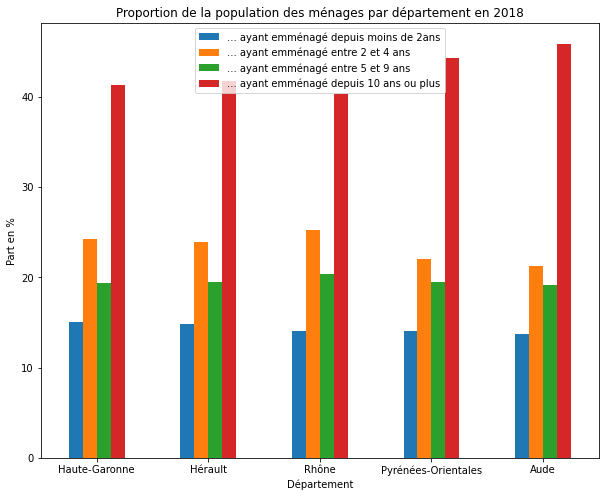

In [7]:
df_PROP_MEN_5P = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002", ascending = False).head()[["P18_PMEN_PROP_0002", "P18_PMEN_PROP_0204", "P18_PMEN_PROP_0509", "P18_PMEN_PROP_10P"]] 
df_PROP_MEN_5P.columns = ["... ayant emménagé depuis moins de 2ans", "... ayant emménagé entre 2 et 4 ans", "... ayant emménagé entre 5 et 9 ans", "... ayant emménagé depuis 10 ans ou plus"]
legend = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002", ascending = False).head()['NOM']
ax  = df_PROP_MEN_5P.plot(kind = "bar")
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 8)
# Change the axes labels
ax.set_xlabel("Département")
ax.set_ylabel("Part en %")
ax.xaxis.set_ticklabels(legend)
plt.xticks(rotation = 'horizontal')
plt.title("Proportion de la population des ménages par département en 2018")
plt.show()


A priori les département 31, 34, 69, 66 et 11 ont le plus attiré de ménages ces deux dernières années

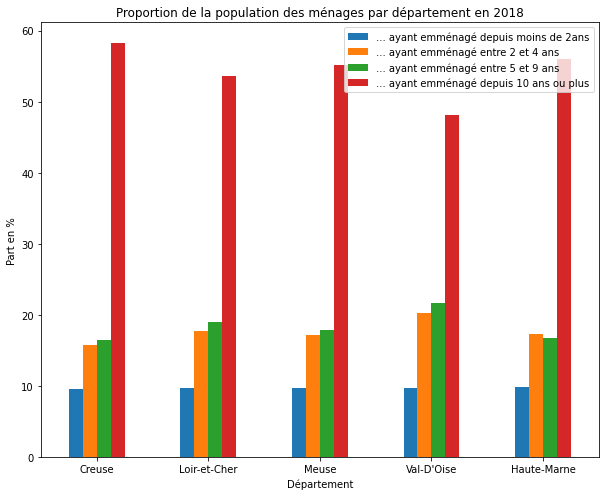

In [10]:
df_PROP_MEN_5D = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002").head()[["P18_PMEN_PROP_0002", "P18_PMEN_PROP_0204", "P18_PMEN_PROP_0509", "P18_PMEN_PROP_10P"]] 
df_PROP_MEN_5D.columns = ["... ayant emménagé depuis moins de 2ans", "... ayant emménagé entre 2 et 4 ans", "... ayant emménagé entre 5 et 9 ans", "... ayant emménagé depuis 10 ans ou plus"]
legend = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002").head()["NOM"]
ax  = df_PROP_MEN_5D.plot(kind = "bar")
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 8)
# Change the axes labels
ax.set_xlabel("Département")
ax.xaxis.set_ticklabels(legend)
ax.set_ylabel("Part en %")
plt.xticks(rotation = 'horizontal')
plt.title("Proportion de la population des ménages par département en 2018")
plt.show()

A l'inverse les départements 23, 41, 55 n'attirent pas tellement de nouveaux ménages proportionnelement à la taille de leur population.

## En valeur absolue quelle département attire le plus de ménages ces deux dernières années

In [12]:
#
df_PMEN_ANEM0002P5 = df.sort_values('P18_PMEN_ANEM0002', ascending = False)[["P18_PMEN_ANEM0002", "NOM"]].head()
df_PMEN_ANEM0002P5

,P18_PMEN_ANEM0002,NOM
DEP,,
75,567146.279419,Paris
13,348085.521781,Bouches-du-Rhône
69,326952.414165,Rhône
59,294216.655042,Nord
97,222430.382474,NaN


In [11]:
df_PMEN_ANEM0204_P5 = df.sort_values('P18_PMEN_ANEM0204', ascending = False)[["P18_PMEN_ANEM0204", "NOM"]].head()
df_PMEN_ANEM0204_P5

,P18_PMEN_ANEM0204,NOM
DEP,,
75,998882.379742,Paris
13,643367.072810,Bouches-du-Rhône
69,584590.398490,Rhône
59,530783.546718,Nord
97,377495.256472,NaN


In [40]:
df_PMEN_P5 = df.sort_values('P18_PMEN', ascending = False)[["P18_PMEN"]].head()
df_PMEN_P5

,P18_PMEN
DEP,
75,4.266917e+06
13,2.828750e+06
59,2.554650e+06
69,2.320613e+06
97,1.860287e+06


In [36]:
data1 = df_PROP_MEN[df_PROP_MEN.index=="31"]
data1

,P18_PMEN,P18_PMEN_ANEM0002,P18_PMEN_ANEM0204,P18_PMEN_ANEM0509,P18_PMEN_ANEM10P,P18_PMEN_PROP_0002,P18_PMEN_PROP_0204,P18_PMEN_PROP_0509,P18_PMEN_PROP_10P
DEP,,,,,,,,,
31,1.353697e+06,203338.862444,328033.727629,262582.122338,559742.628904,15.020999,24.232428,19.397403,41.349171


# Tentative visualisation avec carte

In [1]:
%matplotlib inline


In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
#Visualisation avec carte 

from pyensae.datasource import download_data
try:
    download_data("GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z",
                  website="https://wxs-telechargement.ign.fr/oikr5jryiph0iwhw36053ptm/telechargement/inspire/" + \
                          "GEOFLA_THEME-DEPARTEMENTS_2015_2$GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/file/")
except Exception as e:
    # au cas le site n'est pas accessible
    download_data("GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", website="xd")
    


In [4]:
from pyquickhelper.filehelper import un7zip_files
try:
    un7zip_files("GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", where_to="shapefiles")
    departements = 'shapefiles/GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/GEOFLA/1_DONNEES_LIVRAISON_2015/' + \
                   'GEOFLA_2-1_SHP_LAMB93_FR-ED152/DEPARTEMENT/DEPARTEMENT.shp'
except FileNotFoundError as e:
    # Il est possible que cette instruction ne fonctionne pas.
    # Dans ce cas, on prendra une copie de ce fichier.
    import warnings
    warnings.warn("Plan B parce que " + str(e))
    download_data("DEPARTEMENT.zip")
    departements = "DEPARTEMENT.shp"

if not os.path.exists(departements):
    raise FileNotFoundError("Impossible de trouver '{0}'\ncurrent folder: '{1}'".format(
        departements, os.getcwd()))

ModuleNotFoundError: No module named 'py7zlib'